# Analysis of the Electrical Conductivity of Dissolved Rock Samples
Infos zum Thema können im Dokument mit dem DOI <a href='https://doi.org/10.1002/cepa.2941'>10.1002/cepa.2941</a> gefunden werden. 

## Imports and Definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

import os
import time
import json
import itertools

from glob import glob
from scipy.optimize import curve_fit
from scipy.stats import norm, f
from collections import Counter

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from io import StringIO
import pydotplus

In [2]:
# plot settings, increase font sizes
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.labelspacing'] = 0.2

In [3]:
# exponential decay function to describe the decrease in conductivity
def lf (t, dlf, k, lf1, m=0):
    return dlf * np.exp(-t/k) + m*t + lf1


def lf_err (t, popt, perr):
    err = np.sqrt(perr[0]**2 * (np.exp(-t/popt[1]))**2
                  + perr[1]**2 * (popt[0]*t/popt[1]**2*np.exp(-t/popt[1]))**2 
                  + perr[2]**2 * 1**2
                  + perr[3]**2 * t**2)
    return err

In [4]:
# load the BET values for the different sample types
with open('raw/bet.json') as fd:
    bet = json.load(fd)

## Check Timing

sampling time: (30 +/- 4) s


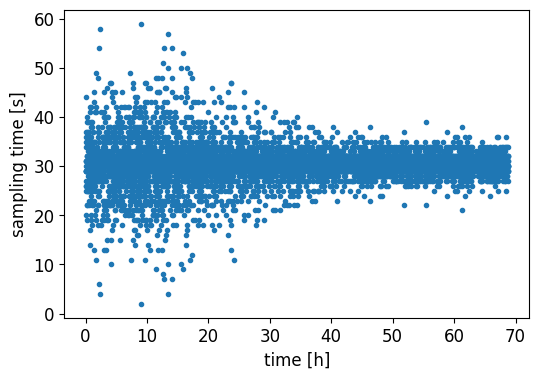

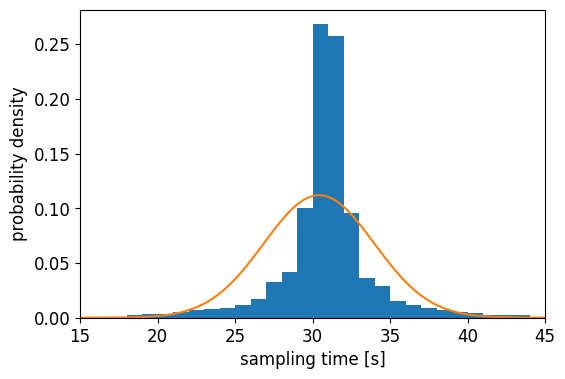

In [5]:
filename = 'raw/timingData/10g Flint.csv'
filename = 'raw/timingData/20200106_OSSN_10g_50C.csv'
filename = 'raw/timingData/20210104_FlintNB_5g_60C.csv'

# load the data file with the full time stamp
df = pd.read_csv(filename).drop([0])

# load date and time and merge them
dateTime = np.asarray([df['Datum'],df['Zeitpunkt']]).T
dateTime = np.asarray([' '.join(dateTime[i]) for i in range(len(df))])

# convert date and time to UNIX timestamp
dateTime = np.asarray([time.mktime(time.strptime(dateTime[i], '%d/%m/%Y %H:%M:%S')) for i in range(len(df)-1)])
#dateTime = dateTime[len(dateTime)//2:]

# calculate the sampling time
samplingTime = np.diff(dateTime)
timePDF = np.linspace(samplingTime.min(), samplingTime.max(), 10001)
bins = np.arange(samplingTime.min(), samplingTime.max()+1, 1)
print('sampling time: ({:.0f} +/- {:.0f}) s'.format(samplingTime.mean(), samplingTime.std()))

# show the time course of the sampling time
fig, ax = plt.subplots()
ax.plot((dateTime[:-1]-dateTime[0])/3600, samplingTime, '.')
ax.set(xlabel='time [h]', ylabel='sampling time [s]')
plt.show()

# show the sampling time histogram and normal distribution
fig, ax = plt.subplots()
ax.hist(samplingTime, bins, density=True)
ax.plot(timePDF, norm(loc=samplingTime.mean(), scale=samplingTime.std()).pdf(timePDF))
ax.set(xlabel='sampling time [s]', ylabel='probability density', xlim=(15, 45))
plt.show()

## Test Set

In [6]:
# sampling time in [h]
# this is an average and could be calculated for each sample
samplingTime = 30 / 3600

# list of all samples
samples = ['CB8000',  #  0
           'CB6000',  #  1
           'CB4000',  #  2
           'CB3000',  #  3
           'QP3LB',   #  4
           'QP1A',    #  5
           'QPJH',    #  6
           'QPVL',    #  7
           'GWWA',    #  8
           'GWOS',    #  9
           'GWHZ',    # 10
           'GWGT',    # 11
           'OSSN',    # 12
           'OSSH',    # 13
           'FLINTNB', # 14
           'FLINTAD', # 15
           'FLINTVB', # 16
           'MS'       # 17
          ]

In [7]:
rawFiles = glob('raw/*_LF.xlsx')
processedFiles = glob('processed/*_LF.csv')

print('number of unprocessed files: {}'.format(len(rawFiles)-len(processedFiles)))

number of unprocessed files: 0


In [22]:
# select the sample from the list above and the weight
sample = samples[17]
# select the weight in [mg]
weight = 3000

# initial fitting parameter, seem to work for everything
popt = (5, 2, 100, -1)
popt = (20, 5, 40, -0.1)

# create the filename
filename = 'raw/{}_{:05d}mg_LF.xlsx'.format(sample, weight)

if os.path.exists(filename):
    
    # load the filename into a dataframe
    df = pd.read_excel(filename)
    
    # create ID array manually or automatically
    # automatically works if there is only one time column
    ID = np.array(df.columns[np.array([type(dfc) for dfc in  df.columns])==int], dtype=int)
    
    # show the columns and the first few lines
    print(f'sample:\t{sample}')
    print(f'weight:\t{weight} mg')
    print(f'IDs:\t{", ".join([str(id) for id in ID])}')
    
    # define the time array
    Time_h = df['Unnamed: 0']*samplingTime

else:

    # print error and help message
    print(f'file "{filename}" does not exist -> check sample and weight')
    print(f'\npossible weights for sample "{sample}" are:')

    for files in sorted(glob('raw/{}_*mg_LF.xlsx'.format(sample))):
        print(f'{int(files.split("_")[1][:-2]):5d} mg')

sample:	MS
weight:	3000 mg
IDs:	10, 11, 68, 69, 82, 83, 504


adj. R²	=	0.984
k	=	(1.95 +/- 0.01) h
lf0	=	(96.34 +/- 0.05) mS/cm
lf0	=	(95.07 +/- 0.01) mS/cm
lf1	=	(90.07 +/- 0.00) mS/cm
dlf	=	(4.99 +/- 0.01) mS/cm
dlfr	=	(0.05 +/- 0.00) mS/cm
m	=	(-0.00 +/- 0.00) mS/cm/h


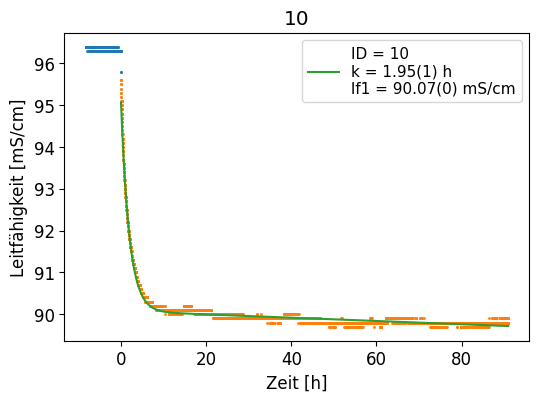

adj. R²	=	0.996
k	=	(2.22 +/- 0.00) h
lf0	=	(95.17 +/- 0.05) mS/cm
lf0	=	(94.41 +/- 0.01) mS/cm
lf1	=	(89.12 +/- 0.00) mS/cm
dlf	=	(5.29 +/- 0.01) mS/cm
dlfr	=	(0.06 +/- 0.00) mS/cm
m	=	(-0.01 +/- 0.00) mS/cm/h


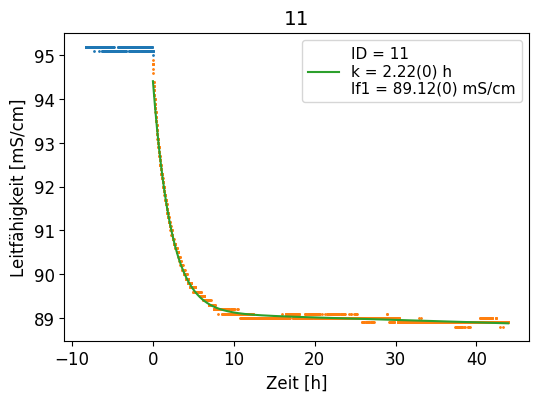

adj. R²	=	0.995
k	=	(2.81 +/- 0.01) h
lf0	=	(87.02 +/- 0.10) mS/cm
lf0	=	(85.80 +/- 0.01) mS/cm
lf1	=	(80.33 +/- 0.00) mS/cm
dlf	=	(5.47 +/- 0.01) mS/cm
dlfr	=	(0.06 +/- 0.00) mS/cm
m	=	(-0.01 +/- 0.00) mS/cm/h


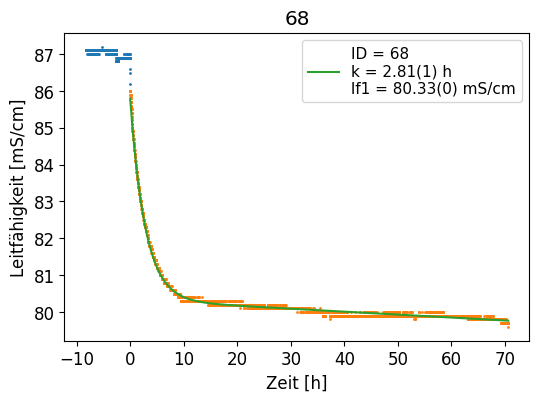

adj. R²	=	0.994
k	=	(3.46 +/- 0.01) h
lf0	=	(44.16 +/- 0.13) mS/cm
lf0	=	(43.86 +/- 0.01) mS/cm
lf1	=	(34.49 +/- 0.00) mS/cm
dlf	=	(9.37 +/- 0.01) mS/cm
dlfr	=	(0.21 +/- 0.00) mS/cm
m	=	(0.00 +/- 0.00) mS/cm/h


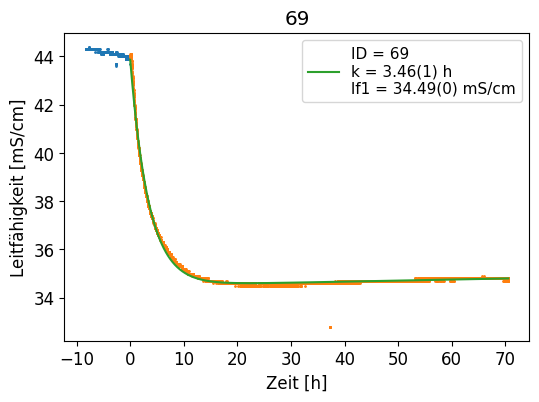

adj. R²	=	0.990
k	=	(2.89 +/- 0.02) h
lf0	=	(97.51 +/- 0.47) mS/cm
lf0	=	(94.57 +/- 0.02) mS/cm
lf1	=	(88.79 +/- 0.02) mS/cm
dlf	=	(5.77 +/- 0.02) mS/cm
dlfr	=	(0.06 +/- 0.00) mS/cm
m	=	(0.01 +/- 0.00) mS/cm/h


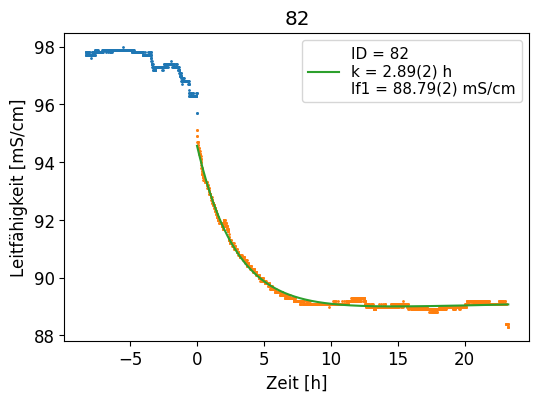

adj. R²	=	0.988
k	=	(2.17 +/- 0.01) h
lf0	=	(52.36 +/- 0.07) mS/cm
lf0	=	(54.31 +/- 0.03) mS/cm
lf1	=	(43.54 +/- 0.02) mS/cm
dlf	=	(10.77 +/- 0.03) mS/cm
dlfr	=	(0.20 +/- 0.00) mS/cm
m	=	(0.05 +/- 0.00) mS/cm/h


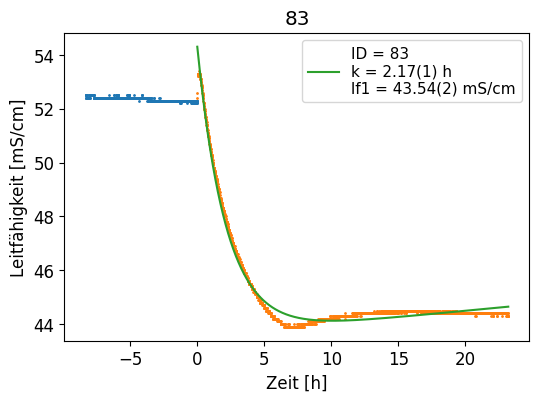

adj. R²	=	0.991
k	=	(2.82 +/- 0.01) h
lf0	=	(95.94 +/- 0.05) mS/cm
lf0	=	(95.32 +/- 0.01) mS/cm
lf1	=	(89.28 +/- 0.00) mS/cm
dlf	=	(6.04 +/- 0.01) mS/cm
dlfr	=	(0.06 +/- 0.00) mS/cm
m	=	(0.00 +/- 0.00) mS/cm/h


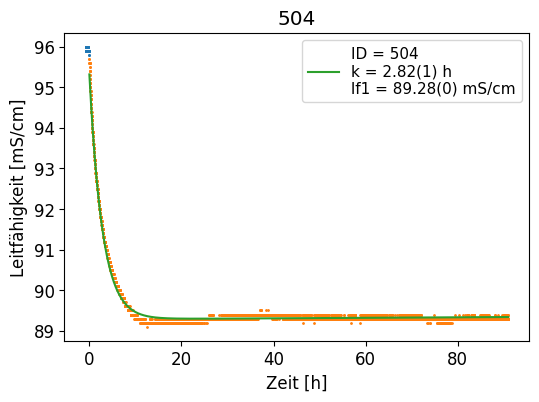

In [25]:
N = len(ID)

lf0_mean = np.zeros((2,N))

dlf_fit = np.zeros((2,N))
k_fit = np.zeros((2,N))
lf1_fit = np.zeros((2,N))
m_fit = np.zeros((2,N))

lf0_calc = np.zeros((2,N))
dlf_rel_calc = np.zeros((2,N))

adjR2 = np.zeros(N)
Fstat = np.zeros(N)
pFstat = np.zeros(N)

for i,id in enumerate(ID):

    # select data to calculate lf0_mean
    mask_m  = (Time_h<0)
    lf0_mean[:,i] = df[id][mask_m].mean(), df[id][mask_m].std()
    
    # select data and perform the fit
    mask = (Time_h>=0) & (df[id].notna()) & (df[id]!=' ')
    popt, pcov = curve_fit(lf, Time_h[mask], df[id][mask], p0=popt, maxfev=100000)
    perr = np.sqrt(np.diag(pcov))

    # number of observations
    n = len(Time_h[mask])
    # number of parameters
    k = len(popt)
    # residuals sum of squares
    SSres = np.sum((df[id][mask] - lf(Time_h[mask],*popt))**2)
    # total sum of squares
    SStot = np.sum((df[id][mask] - np.mean(df[id][mask]))**2)
    # explained of squares
    SSexp = np.sum((lf(Time_h[mask],*popt) - np.mean(df[id][mask]))**2)

    # calculate the adjusted R² value
    adjR2[i] = 1 - (SSres / SStot) * ((n-1) / (n-k-1))

    # calculate the F-statistics
    Fstat[i] = (SSexp / k) / (SSres / (n-k-1))
    pFstat[i] = 1 - f.cdf(Fstat[i], k, n-k-1)

    print(f'adj. R²\t=\t{adjR2[i]:.3f}')

    # calculate the error on the conductivity
    df_err = lf_err(Time_h[mask], popt, perr)

    # save the fitted parameters into the corresponding variable
    dlf_fit[:,i] = popt[0], perr[0]
    k_fit[:,i] = popt[1], perr[1]
    lf1_fit[:,i] = popt[2], perr[2]
    m_fit[:,i] = popt[3], perr[3]

    # calculate the derived parameters
    lf0_calc[:,i] = popt[0]+popt[2], np.sqrt(perr[0]**2+perr[2]**2)
    dlf_rel_calc[:,i] = popt[0]/(popt[0]+popt[2]), np.sqrt((popt[0]**2*perr[2]**2+popt[2]**2*perr[0]**2)/(popt[0]+popt[2])**4)

    # print the relevant fitted parameters
    print('k\t=\t({:.2f} +/- {:.2f}) h'.format(*k_fit[:,i]))
    print('lf0\t=\t({:.2f} +/- {:.2f}) mS/cm'.format(*lf0_mean[:,i]))
    print('lf0\t=\t({:.2f} +/- {:.2f}) mS/cm'.format(*lf0_calc[:,i]))
    print('lf1\t=\t({:.2f} +/- {:.2f}) mS/cm'.format(*lf1_fit[:,i]))
    print('dlf\t=\t({:.2f} +/- {:.2f}) mS/cm'.format(*dlf_fit[:,i]))
    print('dlfr\t=\t({:.2f} +/- {:.2f}) mS/cm'.format(*dlf_rel_calc[:,i]))
    print('m\t=\t({:.2f} +/- {:.2f}) mS/cm/h'.format(*m_fit[:,i]))
    
    # create the label for the figure
    label = 'ID = {}\nk = {:.2f}({:.0f}) h\nlf1 = {:.2f}({:.0f}) mS/cm'.format(id, popt[1], 1e2*perr[1], popt[2], 1e2*perr[2])

    # plot and save the figure
    fig, ax = plt.subplots()
    ax.plot(Time_h[mask_m], df[id][mask_m], '.', ms=2)
    ax.plot(Time_h[mask], df[id][mask], '.', ms=2)
    ax.plot(Time_h[mask], lf(Time_h[mask], *popt), 'C2-', label=label)
    #ax.plot(Time_h[mask], lf(Time_h[mask], *popt)+df_err, 'C2--', lw=1)
    #ax.plot(Time_h[mask], lf(Time_h[mask], *popt)-df_err, 'C2--', lw=1)
    ax.legend(loc='upper right')
    ax.set(title=id, xlabel='Zeit [h]', ylabel='Leitfähigkeit [mS/cm]')
    fig.savefig('plots/{:04d}.png'.format(id))
    plt.show()

In [66]:
header = ('id,'
          'sample,'
          'weight_mg,'
          'lf0_mean,lf0_mean_err,'
          'lf0_calc,lf0_calc_err,'
          'lf1_fit,lf1_fit_err,'
          'dlf_fit,dlf_fit_err,'
          'dlf_rel_calc,dlf_rel_calc_err,'
          'k_fit,k_fit_err,'
          'm_fit,m_fit_err,'
          'adR2,FStat,pFStat')

data = (ID,
        [sample for x in range(N)],
        [weight for x in range(N)],
        *lf0_mean,
        *lf0_calc,
        *lf1_fit,
        *dlf_fit,
        *dlf_rel_calc,
        *k_fit,
        *m_fit,
        adjR2,Fstat,pFstat)

data = np.concatenate(data)
data = data.reshape((len(data)//len(ID),len(ID)))
np.savetxt('processed/{}.csv'.format(filename[4:-5]), data.T, fmt='%s', header=header, delimiter=',')

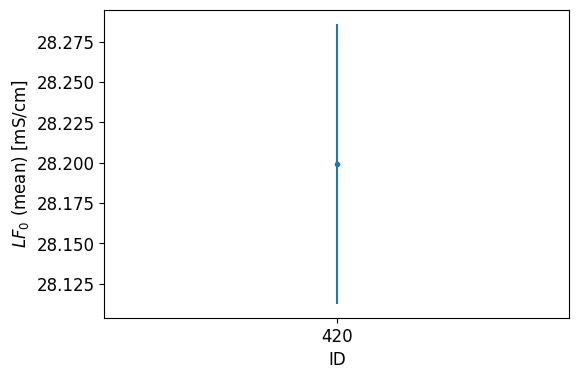

In [67]:
fig, ax = plt.subplots()
ax.errorbar([str(id) for id in ID], *lf0_mean, fmt='.')
ax.set(xlabel='ID', ylabel='$LF_0$ (mean) [mS/cm]')
plt.show()

## Combine Files

In [6]:
# get all files in the processed directory
filenames = sorted(glob('processed/*_LF.csv'))

# combine their content
df_all = pd.concat([pd.read_csv(f) for f in filenames])

# save into new file
df_all.to_csv('processed/combinedData.csv', index=False)

# load the combined data with new indexing
df_all = pd.read_csv('processed/combinedData.csv')

In [7]:
# check for duplicate IDs
numberOfIDs = len(df_all['# id'])
numberOfUniqueIDs = len(set(df_all['# id']))
duplicateIDs = [k for k,v in Counter(df_all['# id']).items() if v>1]
print('number of duplicate IDs: {}'.format(numberOfIDs-numberOfUniqueIDs))
print('IDs:', duplicateIDs)

number of duplicate IDs: 0
IDs: []


In [ ]:
# check for mistakes in the data files and/or data table
df_comp = pd.read_excel('raw/Datenbank_20231119.xlsx', usecols=(0,1,3,4,5), names=('mat','submat','weight','temp','id'), skiprows=2)

for i,da in df_all.iterrows():
    
    mask = df_comp.id.values==da['# id']
    dc = df_comp[mask]
    
    try:
        prob_id = int(da['# id']) != int(dc['id'].values[0])
        prob_weight = int(da['weight_mg']) != int(1e3*dc['weight'].values[0])
        prob_sample = da['sample'] != str(dc['mat'].values[0])+str(dc['submat'].values[0])
        
        if prob_id or prob_weight or prob_sample:
            print('{}\t{}\t{}'.format(dc['id'].values[0], dc['mat'].values[0]+dc['submat'].values[0], int(1e3*dc['weight'].values[0])))
            print('{}\t{}\t{}'.format(da['# id'], da['sample'], da['weight_mg']))
            print('')

    except:
        print('', end='')

## Statistical Analysis

41.3% have R²>0.99


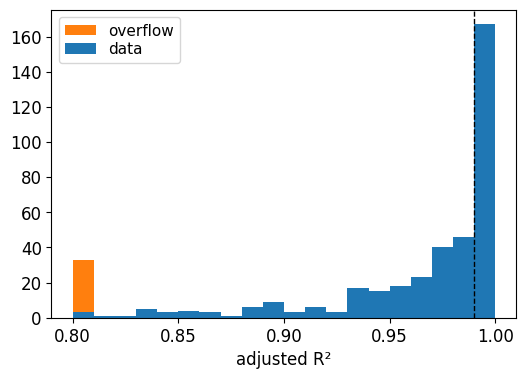

In [30]:
r2_lim = 0.99
print('{:.1f}% have R²>{}'.format(100*len(df_all[df_all.adR2>=r2_lim])/len(df_all), r2_lim))

bins = np.linspace(0.8,1.0,21)
adR2 = np.clip(df_all.adR2, bins[0], bins[-1])

fig, ax = plt.subplots()
ax.hist(adR2, bins, color='C1', label='overflow')
ax.hist(df_all.adR2, bins, color='C0', label='data')
ax.axvline(r2_lim, c='k', ls='--', lw=1)
ax.legend()
ax.set(xlabel='adjusted R²')
ax.set_xticks([0.8,0.85,0.9,0.95,1.0])
plt.show()

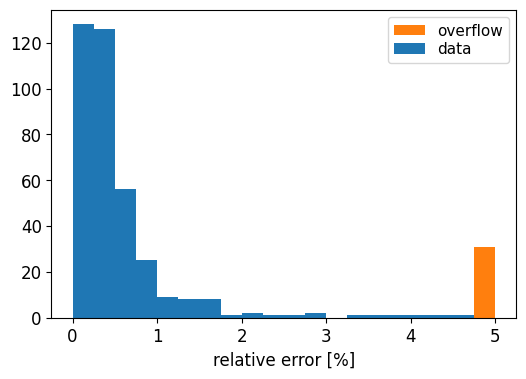

In [31]:
relErr = 100*abs(df_all.dlf_fit_err/df_all.dlf_fit)

bins = np.linspace(0, 5, 21)
relE = np.clip(relErr, bins[0], bins[-1])

fig, ax = plt.subplots()
ax.hist(relE, bins, label='overflow', color='C1')
ax.hist(relErr, bins, label='data', color='C0')
ax.legend()
ax.set(xlabel='relative error [%]')
plt.show()

## Machine Learning Shizzle

### Preprocessing

In [19]:
df_all = pd.read_csv('processed/combinedData.csv', delimiter=',')
print(df_all.shape)
df_all.head()

(294, 17)


,# id,sample,weight,lf0_mean,lf0_mean_err,lf0_calc,lf0_calc_err,lf1_fit,lf1_fit_err,dlf_fit,dlf_fit_err,dlf_rel_calc,dlf_rel_calc_err,k_fit,k_fit_err,m_fit,m_fit_err
0,154,FLINTAD,03g,42.8431,0.153349,42.292895,0.020894,39.439602,0.015590,2.853294,0.013911,0.067465,0.000308,7.023144,0.071792,-0.045374,0.000437
1,155,FLINTAD,03g,57.1019,0.316080,56.306432,0.015723,51.816623,0.010472,4.489809,0.011729,0.079739,0.000192,4.948270,0.029825,-0.060779,0.000329
2,166,FLINTAD,03g,63.7588,0.240833,64.289115,0.020145,59.835045,0.009974,4.454070,0.017502,0.069282,0.000254,3.368527,0.027236,-0.095268,0.000342
3,167,FLINTAD,03g,53.5582,0.230317,52.724526,0.013420,48.378353,0.009455,4.346173,0.009523,0.082432,0.000166,5.560296,0.028117,-0.084324,0.000287
4,178,FLINTAD,03g,67.2073,0.204887,66.372145,0.033404,61.924517,0.023165,4.447629,0.024068,0.067010,0.000339,5.358453,0.067123,-0.100920,0.000711


In [51]:
BET = [bet[sample] for sample in df_all['sample']]

In [52]:
df_all.k_fit = df_all.k_fit / BET

In [230]:
# select features to be included
features = ['weight','lf0_mean','lf0_calc','lf1_fit','k_fit']
#features = ['lf0_mean','lf0_calc','lf1_fit','k_fit']

X = df_all[features].values
X[0:5]

array([['03g', 42.84309999999957, 42.29289541512848, 39.439601883728095,
        7.0231435123533945],
       ['03g', 57.101900000000285, 56.30643234153009, 51.81662288858136,
        4.948269660250596],
       ['03g', 63.758799999999866, 64.28911529971612, 59.835045310606205,
        3.368526553954544],
       ['03g', 53.55820000000022, 52.7245262145943, 48.37835294497816,
        5.5602956868164215],
       ['03g', 67.20729999999976, 66.37214530602509, 61.92451668707978,
        5.358453264733753]], dtype=object)

In [231]:
# encode features
le_weight = preprocessing.LabelEncoder()
le_weight.fit(['03g','05g','08g','10g','12g'])
X[:,0] = le_weight.transform(X[:,0])
X[0:5]

array([[0, 42.84309999999957, 42.29289541512848, 39.439601883728095,
        7.0231435123533945],
       [0, 57.101900000000285, 56.30643234153009, 51.81662288858136,
        4.948269660250596],
       [0, 63.758799999999866, 64.28911529971612, 59.835045310606205,
        3.368526553954544],
       [0, 53.55820000000022, 52.7245262145943, 48.37835294497816,
        5.5602956868164215],
       [0, 67.20729999999976, 66.37214530602509, 61.92451668707978,
        5.358453264733753]], dtype=object)

In [232]:
# normalize the features
# especially important for KNN
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-1.31, -0.76, -0.8 , -0.46,  0.17],
       [-1.31, -0.1 , -0.13,  0.03,  0.03],
       [-1.31,  0.21,  0.25,  0.35, -0.07],
       [-1.31, -0.27, -0.3 , -0.11,  0.07],
       [-1.31,  0.37,  0.35,  0.43,  0.06]])

In [233]:
# define target variable
y = df_all['sample']
y.head()

0    FLINTAD
1    FLINTAD
2    FLINTAD
3    FLINTAD
4    FLINTAD
Name: sample, dtype: object

In [234]:
# split the data into a train and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Decision Tree

In [235]:
# setup the decision tree and train
sampleTree = DecisionTreeClassifier(criterion='entropy', max_depth=4).fit(X_train, y_train)

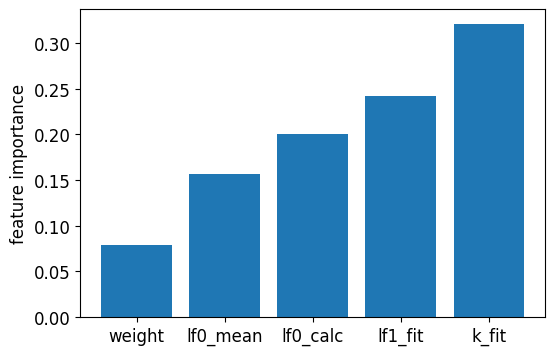

In [236]:
# get the feature importance and show them
featureImportance = sampleTree.feature_importances_

fig, ax = plt.subplots()
ax.bar(features, featureImportance)
ax.set(ylabel='feature importance')
plt.show()

In [237]:
# predict some samples
predTree = sampleTree.predict(X_test)

# compare some predictions with the true values
print(predTree[0:5])
print(y_test[0:5].values)

['GWWA' 'FLINTNB' 'MS' 'GWGT' 'MS']
['GWHZ' 'FLINTAD' 'MS' 'GWOS' 'MS']


In [238]:
# check accuracy of model
print('decision trees accuracy: {:.1f}%'.format(100*metrics.accuracy_score(y_test, predTree)))

decision trees accuracy: 39.0%


In [239]:
classes = ['FLINTAD', 'FLINTNB', 'OSSH', 'OSSN', 'MS', 'GWOS', 'GWGT', 'GWWA', 'GWHZ']
confMat = metrics.confusion_matrix(y_test, predTree, labels=classes)

confMat_norm = confMat.astype('float') / confMat.sum(axis=1)[:, np.newaxis]
classAccuracy = confMat_norm.diagonal()

for cl,ac in zip(classes, classAccuracy):
    print('{:>8}:{: 4.0f}%'.format(cl, 100*ac))

 FLINTAD:   0%
 FLINTNB:  56%
    OSSH:  17%
    OSSN:  67%
      MS:  60%
    GWOS:   0%
    GWGT:  38%
    GWWA:  50%
    GWHZ:  50%


In [240]:
confMat

array([[0, 3, 2, 0, 0, 0, 0, 0, 0],
       [3, 5, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 2, 0, 0],
       [0, 0, 1, 4, 1, 0, 0, 0, 0],
       [1, 0, 1, 2, 6, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 5],
       [0, 0, 0, 0, 1, 0, 1, 2, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 2]])

Confusion matrix, without normalization


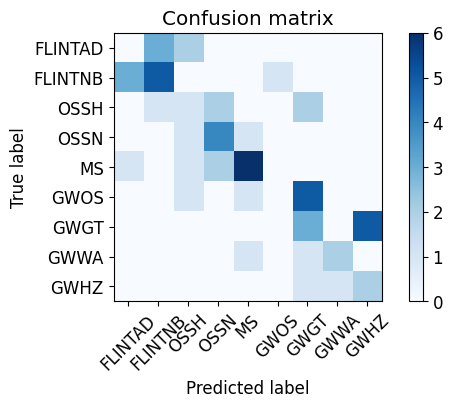

In [241]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confMat, classes=classes, title='Confusion matrix')

In [167]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #    plt.text(j, i, format(cm[i, j], fmt),
    #             horizontalalignment="center",
    #             color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print(metrics.confusion_matrix(y_test, predTree))

[[1 3 0 2 0 0 1 0 0]
 [3 4 0 0 1 1 0 1 1]
 [4 1 1 0 0 2 1 1 0]
 [0 1 0 1 0 0 0 1 0]
 [2 1 1 1 0 1 0 0 0]
 [0 1 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 4 1]
 [2 0 0 1 0 0 0 0 0]
 [2 2 1 0 0 1 2 1 2]]


#### Resampling

In [242]:
N_rs = 1000

ConfMat = np.zeros((N_rs,len(classes),len(classes)))

for n_rs in range(N_rs):
    
    # split the data into a train and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # setup the decision tree and train
    sampleTree = DecisionTreeClassifier(criterion='entropy', max_depth=4).fit(X_train, y_train)
    
    # predict some samples
    predTree = sampleTree.predict(X_test)
    
    # calculate confusion matrix
    confMat = metrics.confusion_matrix(y_test, predTree, labels=classes)

    ConfMat[n_rs] = confMat

In [243]:
confMat = np.mean(ConfMat, axis=0)

In [244]:
confMat_norm = confMat.astype('float') / confMat.sum(axis=1)[:, np.newaxis]
classAccuracy = confMat_norm.diagonal()

for cl,ac in zip(classes, classAccuracy):
    print('{:>8}:{: 4.0f}%'.format(cl, 100*ac))

 FLINTAD:  18%
 FLINTNB:  58%
    OSSH:  35%
    OSSN:  36%
      MS:  40%
    GWOS:  14%
    GWGT:  28%
    GWWA:  56%
    GWHZ:  21%


Confusion matrix, without normalization


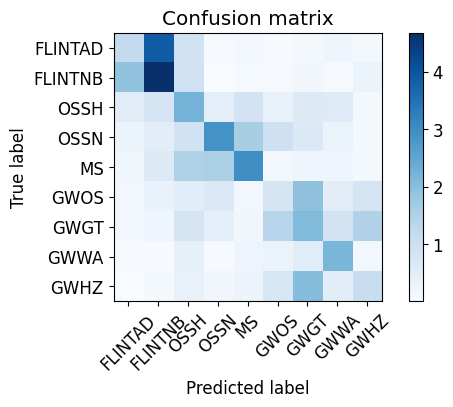

In [245]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confMat, classes=classes, normalize=False, title='Confusion matrix')

#### Tree Diagram

### K nearest neighbor (KNN)

In [281]:
# train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)

In [282]:
# predict some samples
predTree = neigh.predict(X_test)

# compare some predictions with the true values
print(predTree[0:5])
print(y_test[0:5].values)

['OSSH' 'GWGT' 'GWOS' 'GWGT' 'MS']
['OSSH' 'GWGT' 'GWOS' 'GWOS' 'MS']


In [283]:
# check accuracy of model
print('KKN accuracy: {:.1f}%'.format(100*metrics.accuracy_score(y_test, predTree)))

KKN accuracy: 48.2%


### Logistic Regression

In [284]:
LR = LogisticRegression(C=0.5, solver='liblinear').fit(X_train,y_train)

In [285]:
# predict some samples
predTree = LR.predict(X_test)

# compare some predictions with the true values
print(predTree[0:5])
print(y_test[0:5].values)

['OSSH' 'GWOS' 'MS' 'GWHZ' 'MS']
['OSSH' 'GWGT' 'GWOS' 'GWOS' 'MS']


In [286]:
# check accuracy of model
print('Logistic regression accuracy: {:.1f}%'.format(100*metrics.accuracy_score(y_test, predTree)))

Logistic regression accuracy: 39.8%


### Support Vector Machine SVM

In [287]:
clf = svm.SVC(kernel='rbf').fit(X_train, y_train) 

In [288]:
# predict some samples
predTree = clf.predict(X_test)

# compare some predictions with the true values
print(predTree[0:5])
print(y_test[0:5].values)

['OSSH' 'GWOS' 'FLINTAD' 'GWHZ' 'MS']
['OSSH' 'GWGT' 'GWOS' 'GWOS' 'MS']


In [289]:
# check accuracy of model
print('SVM accuracy: {:.1f}%'.format(100*metrics.accuracy_score(y_test, predTree)))

SVM accuracy: 42.2%
